Here we consider TTGO for various 2D benchmark functions without conditioning (task parameters).

Try:
 - 2D Rosenbrock function (unique global optima)
 - 2D Himmelblaue function (multiple global optima)
 - 2D GMM (multiple/unique global optima)
 - 2D Sine function ( infinite number of global optima)
 - Something of your own
 

Copyright (c) 2008 Idiap Research Institute, http://www.idiap.ch/

Written by Suhan Shetty <suhan.shetty@idiap.ch>,


In [1]:
import torch
import numpy as np
import sys
sys.path.append('../')
from ttgo import TTGO
from fcn_plotting_utils import plot_surf, plot_contour
%load_ext autoreload
np.set_printoptions(precision=3)
%autoreload 2

##### Define the objective function (a pdf, need not be normalized)

Activate one of the following cells:

In [2]:
#Himmelbalue2D
from test_fcns import Himmelblaue_2D
L=5
n = 2 # Dimension of the domain
a=11; b=7;
pdf, cost = Himmelblaue_2D(alpha=1, a=a, b=b)
print("This has multiple global optima")
z_max = 2000 # for plotting

This has multiple global optima


##### or

In [3]:
# # Rosenbrock 2D
# from test_fcns import Rosenbrock_2D
# L=2
# n = 2 # Dimension of the domain
# a=1;b=100
# pdf, cost = Rosenbrock_2D(a=a,b=b,alpha=1)
# print("Global optima is at: ", (a,a**2))
# z_max = 2000 # for plotting

or

In [4]:
# # Sine 2D
# from test_fcns import sine_nD
# L=2
# n = 2 # Dimension of the domain
# pdf, cost = sine_nD(n=n)
# print("An infinite number of solutions exist ")
# z_max = 2 # for plotting

##### or

In [5]:
# # Mixture of Gaussians (un-normalized)
# from test_fcns import gmm 
# L = 2
# n = 2 # Dimension of the domain
# nmix = 4
# mx_coef = np.random.uniform(0,1,(nmix,))
# mx_coef = torch.from_numpy(mx_coef/np.sum(mx_coef))
# mu = torch.from_numpy(np.random.uniform(-L,L,(nmix,n)))
# pdf, cost = gmm(n=n,nmix=nmix,L=L,mx_coef=mx_coef,mu=mu,s=0.05)
# print("centers: ",mu)
# print("\nPDF at centers: ", pdf(mu))
# z_max = 2 # for plotting

##### Discretize the domain

In [6]:
# Define the domain of the function
d = 500 # discretization of each axis
domain = [torch.linspace(-L,L,d)]*2

##### Find the TT-Model

In [7]:
ttgo = TTGO(domain=domain,pdf=pdf,cost=cost)
ttgo.cross_approximate(rmax=100, nswp=20, kickrank=5)
ttgo.round(eps=1e-3) # compress the tt-model
print("TT-Rank: ", ttgo.tt_model.ranks_tt)

cross device is cpu
Cross-approximation over a 2D domain containing 250000 grid points:
Note: The algorithm converges as the ratio tt-new-norm/tt-old-norm settles to 1. For TTGO, the convergence is not important, just keep iterating as long as the ratio > 1
iter: 0  | tt-new-norm/tt-old-norm: 2.154e-02 | time:   0.0037 | largest rank:   1
iter: 1  | tt-new-norm/tt-old-norm: 2.097e+00 | time:   0.0086 | largest rank:   6
iter: 2  | tt-new-norm/tt-old-norm: 1.028e+00 | time:   0.0141 | largest rank:  11
iter: 3  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0196 | largest rank:  16
iter: 4  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0288 | largest rank:  21
iter: 5  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0358 | largest rank:  26
iter: 6  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0425 | largest rank:  31
iter: 7  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0488 | largest rank:  36
iter: 8  | tt-new-norm/tt-old-norm: 1.000e+00 | time:   0.0576 | largest rank:

##### Sample from the TT-distribution (no conditioning)

In [8]:
n_samples = 50 
alpha = 0.5 # choose prioritized sampling parameter (0,1)
samples, samples_idx = ttgo.sample(n_samples=n_samples, alpha=alpha, norm=1) 

Choose the best solution (or top-k solution)

In [9]:
best_estimate = ttgo.choose_best_sample(samples) # best estimate
k = 4 # number of solutions needed
top_k_estimate = ttgo.choose_top_k_sample(samples,k=k) # top-k estimates for multiple solutions

In [10]:
print("Cost at estimated optima: ", cost(best_estimate).numpy())
print("Cost at top-k proposals: ", cost(top_k_estimate).numpy())

Cost at estimated optima:  [0.051]
Cost at top-k proposals:  [0.051 0.056 0.08  0.082]


Fine tune the TTGO estimate using gradient-based optimization

In [11]:
ttgo_optimized, _ = ttgo.optimize(best_estimate)
print("Optimal cost: ", cost(ttgo_optimized))
print("Optimal pdf: ", pdf(ttgo_optimized))

Optimal cost:  tensor([0.0001])
Optimal pdf:  tensor([0.9999])


In [12]:
print("TTGO Approximation of Optima: ", best_estimate)
print("Optima: ", ttgo_optimized)

TTGO Approximation of Optima:  tensor([[3.0361, 1.9539]])
Optima:  tensor([[2.9985, 1.9995]])


In [13]:
ttgo_optimized_k = 1*top_k_estimate
for i, x in enumerate(ttgo_optimized_k):
    ttgo_optimized_k[i],_ = ttgo.optimize(x)


### Visualize  Samples from TT Model

In [14]:
def cost_plot(x):
    x = torch.from_numpy(x)
    out =  cost(x)
    if not (type(out) is np.ndarray):
        out = out.numpy()
    return out
def pdf_plot(x):
    x = torch.from_numpy(x)
    out =  pdf(x)
    if not (type(out) is np.ndarray):
        out = out.numpy()
    return out

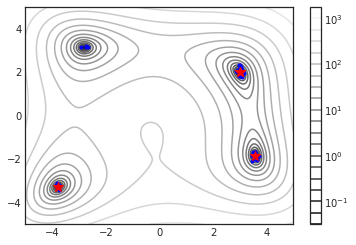

In [15]:
x = np.linspace(-L,L,d)
y = np.linspace(-L,L,d)
plt = plot_contour(x,y,cost_plot,data=samples, contour_scale=100, figsize=5)
plt.plot(ttgo_optimized_k[:,0],ttgo_optimized_k[:,1],'*r',markersize=10)
# plt.plot(best_estimate[:,0],best_estimate[:,1],'*r',markersize=10)

# plt.title("Cost")

#plt.title(r"Himmelblau: $z=(x^2+y-{})^2+(x+y^2-{})^2$".format(a,b))
#plt.title(r"Rosenbrock: $z=(x-1)^2+100 (y-x^2)^2$".format(11,7))

# plt.savefig('rosenbrock2D_a_99.png',pad_inches=0.01, dpi=300)
# plt.savefig('Himmelblau2D_99.png',pad_inches=0.01, dpi=300)
# plt.savefig('Sine2D_a_0.png',pad_inches=0.01, dpi=300)